In [28]:
# encoding 
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

df = pd.read_csv('nyc_subway_ml_data.csv')

# label encoding - station
le_enc = LabelEncoder()
df['station_enc'] = le_enc.fit_transform(df['station'])

#save map
station_map = dict(zip(le_enc.transform(le_enc.classes_), le_enc.classes_))

# one hot encoding - borough
df = pd.get_dummies(df, columns = ['borough'], prefix = 'boro')
df= df.drop(['station', 'transaction_time'], axis = 1)

# scale the entry_per_hour
scaler = MinMaxScaler()
cols_to_scale = ['entry_per_hour', 'hr_lag', 'day_lag', 'week_lag']
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df = df.astype(float)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429600 entries, 0 to 429599
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   entry_per_hour  429600 non-null  float64
 1   hour            429600 non-null  float64
 2   weekday         429600 non-null  float64
 3   month           429600 non-null  float64
 4   is_weekend      429600 non-null  float64
 5   is_rush_hr      429600 non-null  float64
 6   is_holiday      429600 non-null  float64
 7   hr_lag          429600 non-null  float64
 8   day_lag         429600 non-null  float64
 9   week_lag        429600 non-null  float64
 10  station_enc     429600 non-null  float64
 11  boro_Bronx      429600 non-null  float64
 12  boro_Brooklyn   429600 non-null  float64
 13  boro_Manhattan  429600 non-null  float64
 14  boro_Queens     429600 non-null  float64
dtypes: float64(15)
memory usage: 49.2 MB
None


,entry_per_hour,hour,weekday,month,is_weekend,is_rush_hr,is_holiday,hr_lag,day_lag,week_lag,station_enc,boro_Bronx,boro_Brooklyn,boro_Manhattan,boro_Queens
0,0.022164,0.0,6.0,1.0,1.0,0.0,0.0,0.035006,0.024841,0.023255,0.0,0.0,0.0,1.0,0.0
1,0.003273,0.0,6.0,1.0,1.0,0.0,0.0,0.006099,0.003520,0.006892,1.0,0.0,0.0,0.0,1.0
2,0.006049,0.0,6.0,1.0,1.0,0.0,0.0,0.011255,0.005900,0.010413,2.0,0.0,0.0,1.0,0.0
3,0.035998,0.0,6.0,1.0,1.0,0.0,0.0,0.051220,0.038328,0.047650,3.0,0.0,0.0,1.0,0.0
4,0.030643,0.0,6.0,1.0,1.0,0.0,0.0,0.045319,0.031733,0.034113,4.0,0.0,0.0,1.0,0.0


In [29]:
# 1. Random Forest Regressor 
# Jan - Oct: training Nov, Dec: testing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

divide_month = 10
training_data = df[df['month'] <= divide_month]
X_train = training_data.drop(columns = 'entry_per_hour')
y_train = training_data['entry_per_hour']

testing_data = df[df['month'] > divide_month]
X_test = testing_data.drop('entry_per_hour', axis = 1)
y_test = testing_data['entry_per_hour']

rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 67)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse) 
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f'R2 Score (Accuracy): {r2:.4f}') 
print(f'RMSE: {rmse:.4f}')
print(f'MAE:  {mae:.4f}')

R2 Score (Accuracy): 0.9651
RMSE: 0.0146
MAE:  0.0062


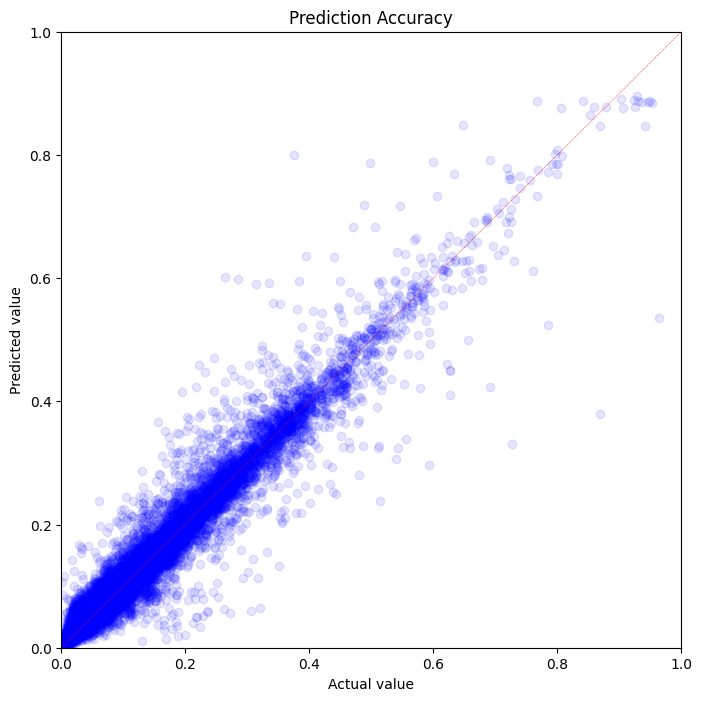

In [30]:
# some visualization of the regressor model 
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize = (8, 8))
plt.scatter(y_test, pred, alpha = 0.1, color = 'blue')
plt.plot([0, 1], [0, 1], color = 'red', linestyle = '--', linewidth = 0.3)

plt.title("Prediction Accuracy")
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

/var/folders/8q/3bk4mhcd2l38k0_tbmtbbsv80000gn/T/ipykernel_15793/2543722010.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


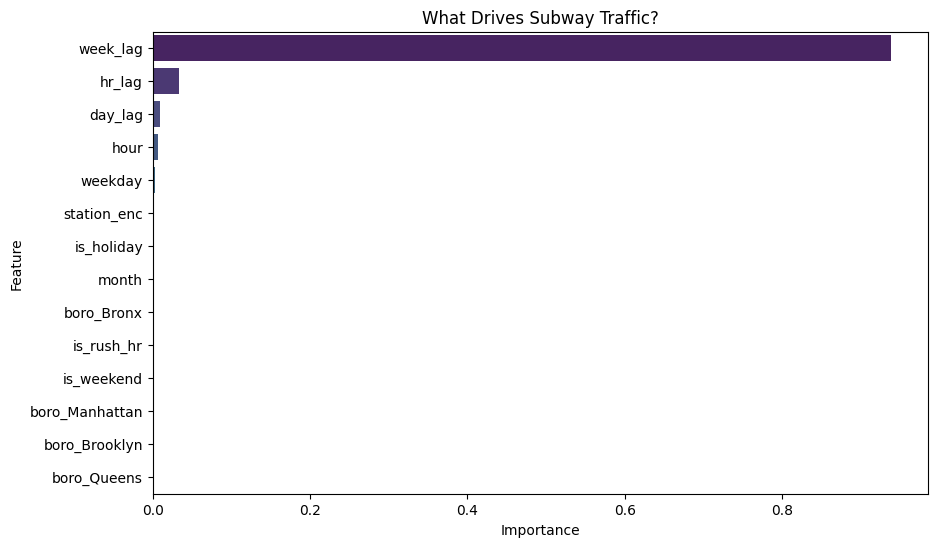

In [31]:
importances = rf.feature_importances_
feature_names = X_train.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('What Drives Subway Traffic?')
plt.show()

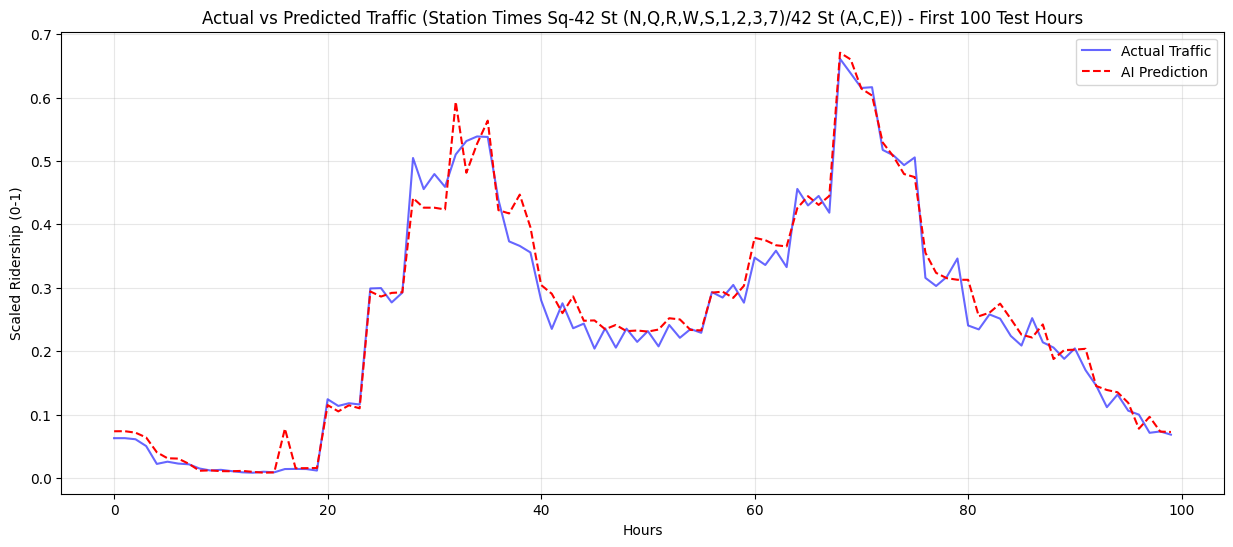

In [32]:
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = pred

target_station = 48
subset = results_df[results_df['station_enc'] == target_station]

subset = subset.sort_values(by=['month', 'weekday', 'hour'])
plt.figure(figsize=(15, 6))
plt.plot(subset['Actual'].values[:100], label='Actual Traffic', color='blue', alpha=0.6)
plt.plot(subset['Predicted'].values[:100], label='AI Prediction', color='red', linestyle='--')

plt.title(f"Actual vs Predicted Traffic (Station {station_map[target_station]}) - First 100 Test Hours")
plt.xlabel("Hours")
plt.ylabel("Scaled Ridership (0-1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
df2 = pd.read_csv('nyc_subway_ml_data.csv')

# label encoding - station
le_enc = LabelEncoder()
df2['station_enc'] = le_enc.fit_transform(df2['station'])

#save map
station_map = dict(zip(le_enc.transform(le_enc.classes_), le_enc.classes_))

# one hot encoding - borough
df2 = pd.get_dummies(df2, columns = ['borough'], prefix = 'boro')
df2 = df2.drop(['station', 'transaction_time'], axis = 1)

month_cutoff = 10
training_data = df2[df2['month'] <= month_cutoff]
X_train = training_data.drop('entry_per_hour', axis = 1)
y_train = training_data['entry_per_hour']

testing_data = df2[df2['month'] > month_cutoff]
X_test = testing_data.drop('entry_per_hour', axis = 1)
y_test = testing_data['entry_per_hour']

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

print("Shape of y_train:", y_train.shape)
print("Max ridership:", y_train.max())
print("Average ridership:", y_train.mean())
print("Sample of values:", y_train.head(10).tolist())

Shape of y_train: (356400,)
Max ridership: 20168.0
Average ridership: 1180.2698
Sample of values: [447.0, 66.0, 122.0, 726.0, 618.0, 1148.0, 56.0, 138.0, 224.0, 183.0]


In [43]:
# Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, verbose = 1)

model = Sequential()

model.add(Dense(256, input_dim = X_train.shape[1], activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))

model.compile(loss = 'mean_absolute_error', optimizer = 'adam')
history = model.fit(X_train_scaled, y_train, epochs = 100, batch_size = 64, 
                    validation_data = (X_test_scaled, y_test), callbacks = [early_stopping, lr_scheduler], verbose = 1)


Epoch 1/100


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5569/5569 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 208.3744 - val_loss: 185.5697 - learning_rate: 0.0010
Epoch 2/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 173.1403 - val_loss: 153.1037 - learning_rate: 0.0010
Epoch 3/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 167.5757 - val_loss: 160.1833 - learning_rate: 0.0010
Epoch 4/100
5562/5569 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 164.3326
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 163.6942 - val_loss: 168.2859 - learning_rate: 0.0010
Epoch 5/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 157.5063 - val_loss: 157.7764 - learning_rate: 5.0000e-04
Epoch 6/100
5542/5569 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156.1621
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 156.0068 - val_loss: 170.5095 - learning_rate: 5.0000e-04
Epoch 7/100
5569/5569 ━━━━━━━━

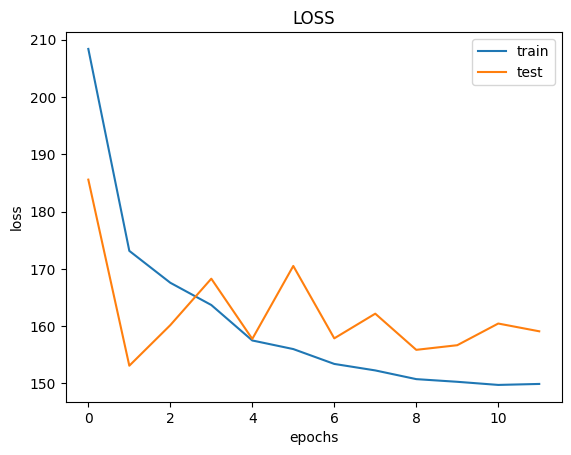

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

2288/2288 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step


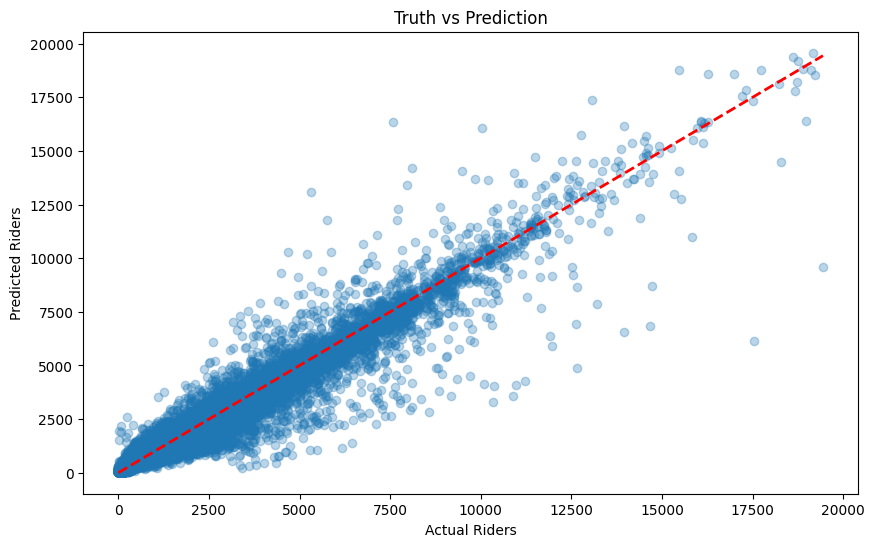

In [48]:
# 1. Get predictions
predictions = model.predict(X_test_scaled)

# 2. Make a simple plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('Actual Riders')
plt.ylabel('Predicted Riders')
plt.title('Truth vs Prediction')
plt.show()